In [1]:
# Look at the distributions of variables
# Maybe try to normalise (gaussianise) them

In [2]:
# http://www.public.iastate.edu/~pdixon/stat505/Chapter%2011.pdf

# Conclusion - this data is, if you assume *sorta normal*, in general heavily censored
# which is to say

In [3]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

BES_data_folder = "../BES_analysis_data/"
BES_code_folder = "../BES_analysis_code/"

from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, MICE

Using Theano backend.


In [4]:
import holoviews as hv
hv.notebook_extension()

In [5]:
%%time
BES_Panel   = pd.read_stata( BES_data_folder+"BES2015_W8_v1.3.dta") # 130Mb
print("BES_Panel", BES_Panel.shape )
BES_numeric = pd.read_hdf( BES_data_folder+"BESW8numeric.hdf", "BESW8numeric" )
print("BES_numeric",  BES_numeric.shape )
var_type    = pd.read_hdf( BES_data_folder+"var_type.hdf", "var_type" )
print("var_type",  var_type.shape )

BES_Panel (31409, 733)
BES_numeric (31409, 659)
var_type (733, 1)
Wall time: 12.8 s


In [6]:
#  0, 1, 2, 5, 6
ordinal_list = var_type[ var_type["type"].apply(lambda x: x in [0, 1, 2, 5, 6]) ].index


opts_per_cat = BES_numeric.apply(lambda x: len(pd.unique(x.dropna()))).sort_values()
two_opt_cats = opts_per_cat[opts_per_cat==2].index

ordinal_more_than_two_opts = ordinal_list.difference(two_opt_cats)
ordinal_more_than_two_opts

Index(['Age', 'EUIntegrationCon', 'EUIntegrationGreen', 'EUIntegrationLD',
       'EUIntegrationLab', 'EUIntegrationPC', 'EUIntegrationSNP',
       'EUIntegrationSelf', 'EUIntegrationSelfW9', 'EUIntegrationUKIP',
       ...
       'ukCoopCAP', 'ukCoopEuro', 'ukCoopMovement', 'ukCoopTrade',
       'ukCoopWorkers', 'ukipUnited', 'ukipUnitedW9', 'voteMethodW9',
       'welshness', 'welshnessW9'],
      dtype='object', length=348)

In [7]:
# test for normality
# test for unimodality


BES_numeric[ordinal_more_than_two_opts].apply(lambda x: len(pd.unique(x.dropna()))).value_counts()

5      123
11     119
4       37
3       36
7       21
21       2
8        2
6        2
101      1
76       1
75       1
16       1
15       1
14       1
dtype: int64

In [8]:
BES_numeric[ordinal_more_than_two_opts].stack().value_counts().sort_index()

0.0      1178831
1.0      1103704
2.0      1327031
3.0      1064585
4.0       642152
5.0       363564
6.0       272495
7.0       179950
8.0       138732
9.0        70040
10.0      166788
11.0        4365
12.0        4654
13.0        4101
14.0        3526
15.0        3927
16.0        3155
17.0        2446
18.0        2414
19.0        2011
20.0        2129
21.0         689
22.0         763
23.0         701
24.0         722
25.0         906
26.0        1050
27.0         721
28.0         651
29.0         692
          ...   
71.0        1065
72.0         983
73.0         785
74.0         677
75.0         817
76.0         953
77.0         573
78.0         442
79.0         307
80.0         296
81.0         231
82.0         173
83.0         154
84.0         129
85.0         142
86.0         117
87.0          58
88.0          63
89.0          67
90.0          70
91.0          42
92.0          54
93.0          41
94.0          31
95.0          51
96.0          30
97.0          65
98.0         1

b':HoloMap   [question_no]\n   :Histogram   [x]   (Frequency)'
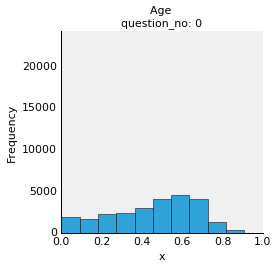
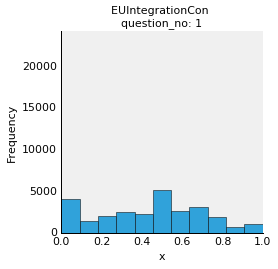
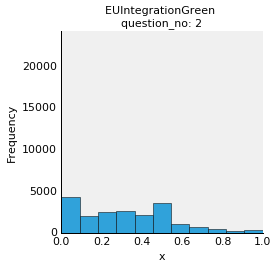
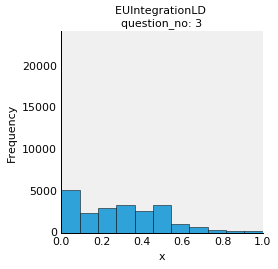
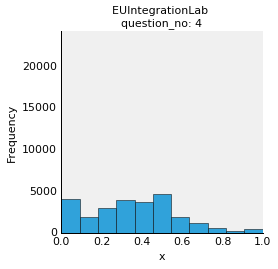
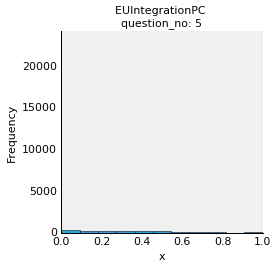
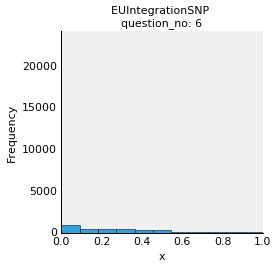
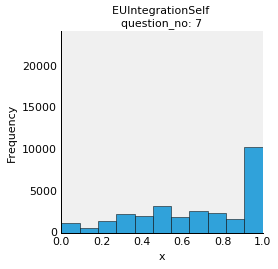
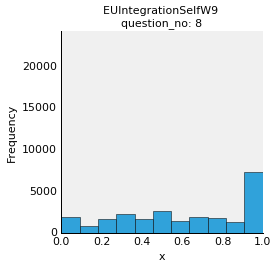
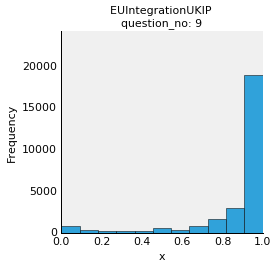
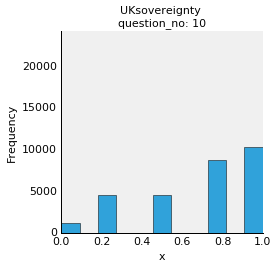
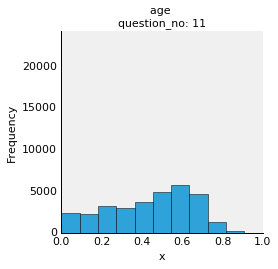
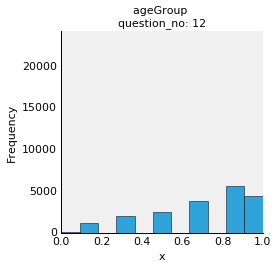
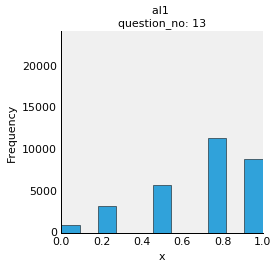
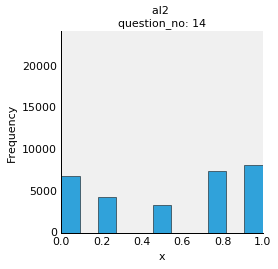
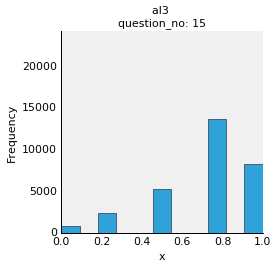
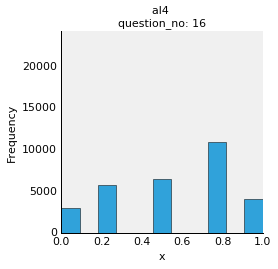
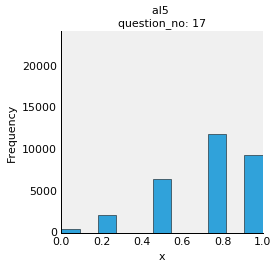
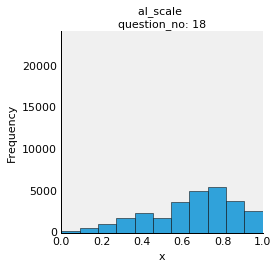
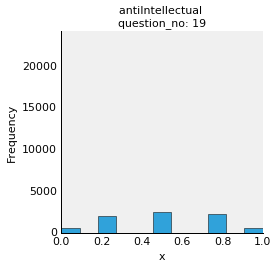
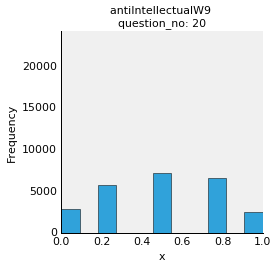
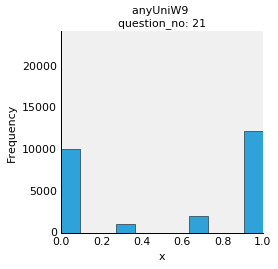
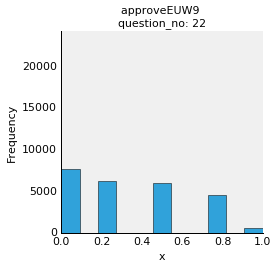
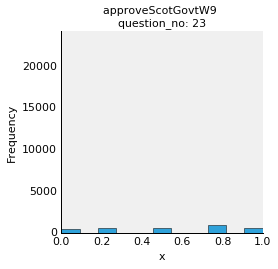
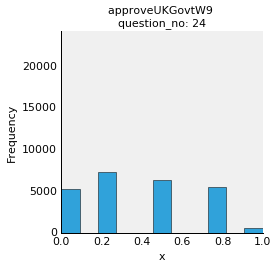
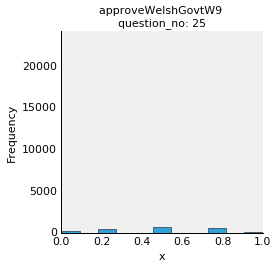
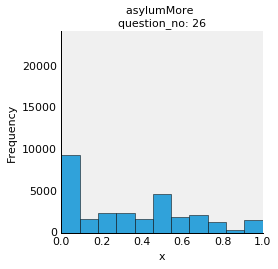
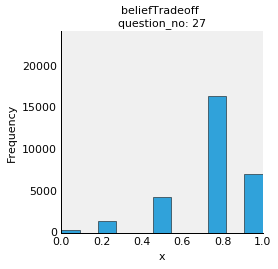
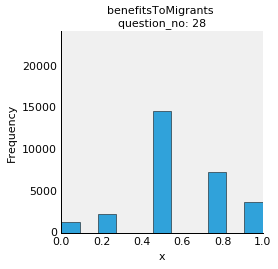
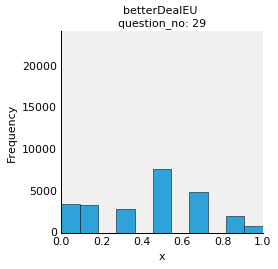
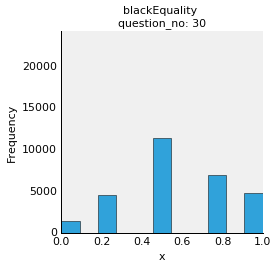
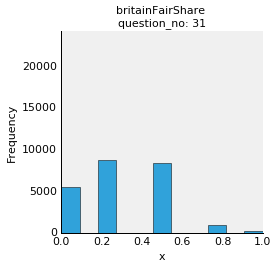
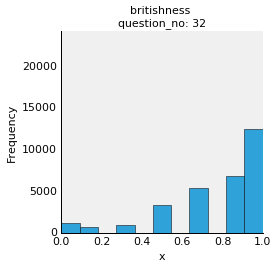
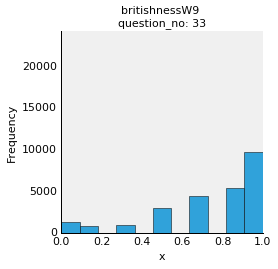
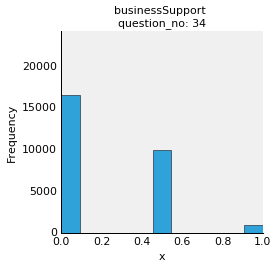
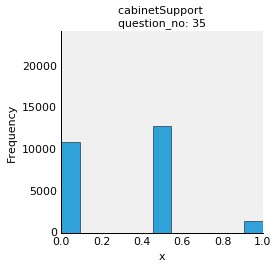
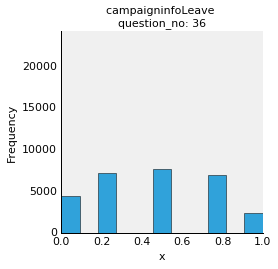
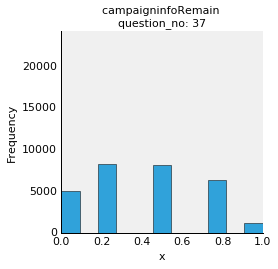
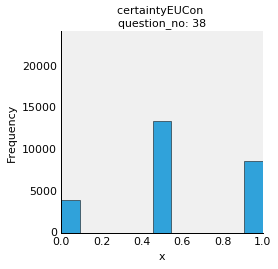
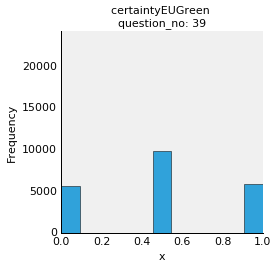
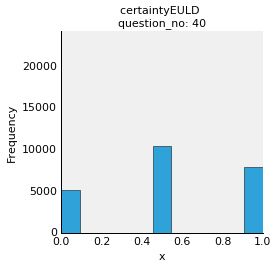
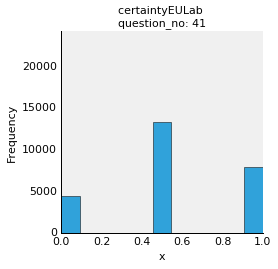
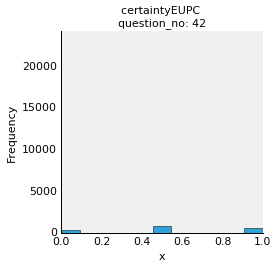
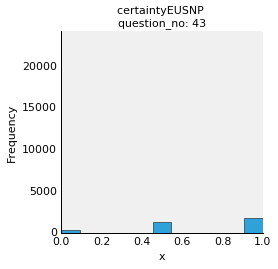
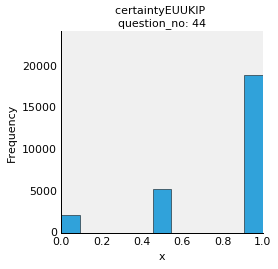
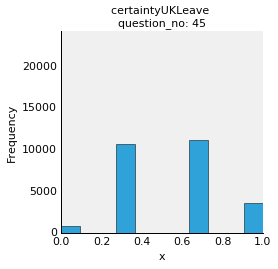
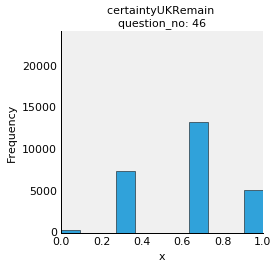
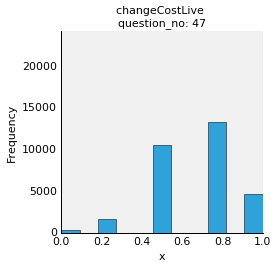
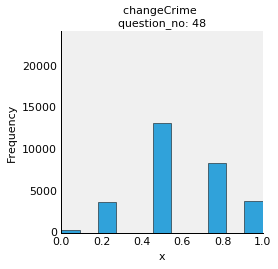
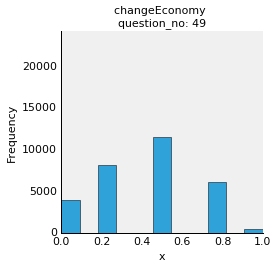
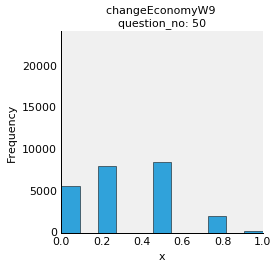
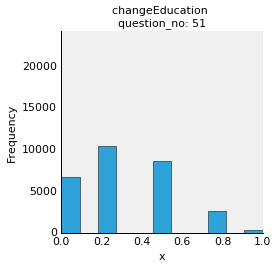
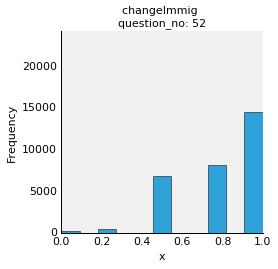
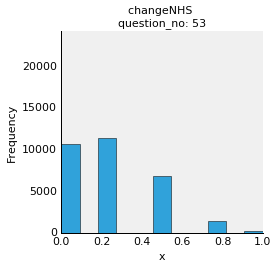
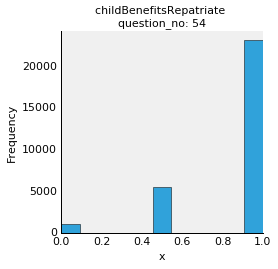
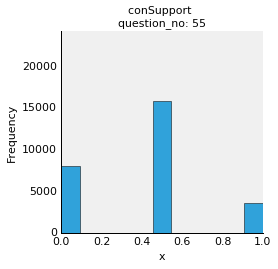
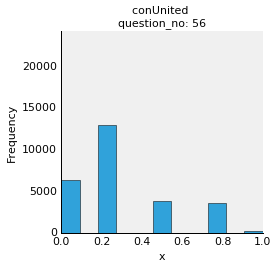
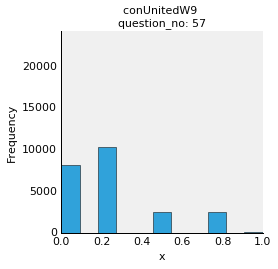
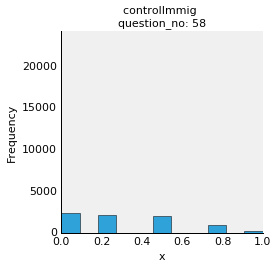
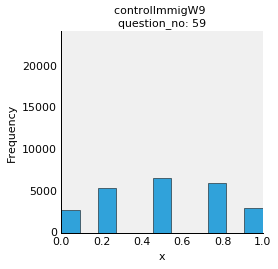
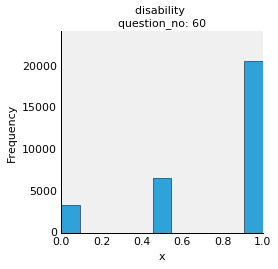
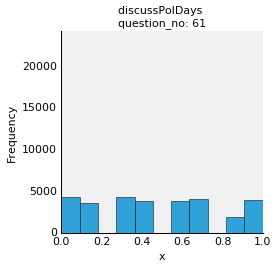
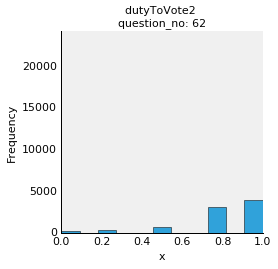
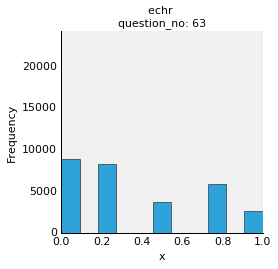
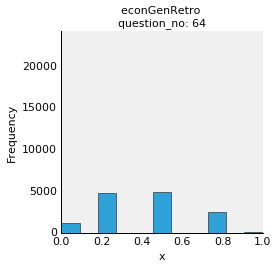
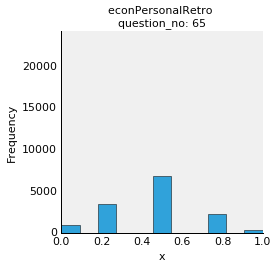
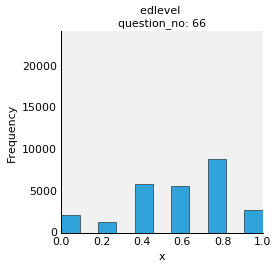
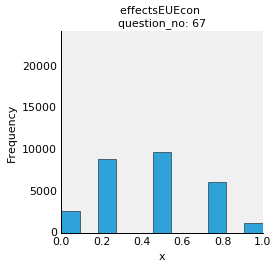
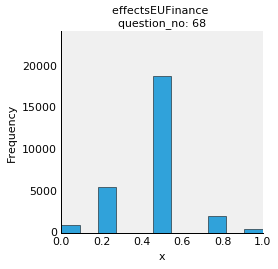
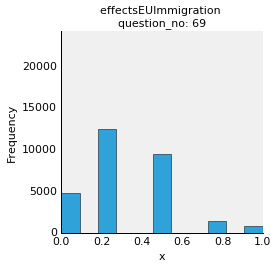
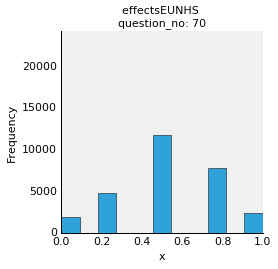
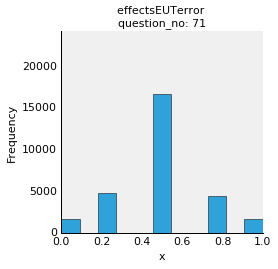
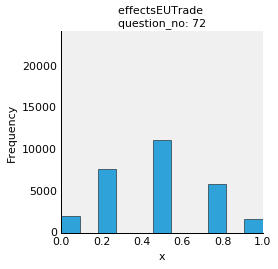
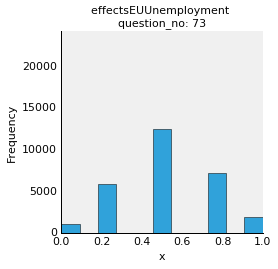
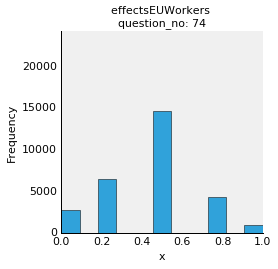
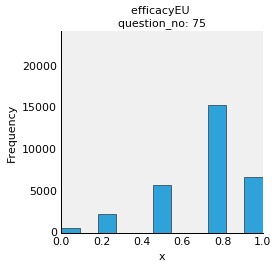
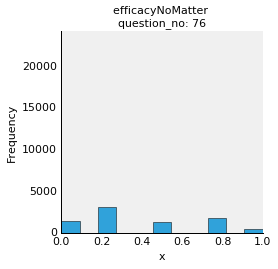
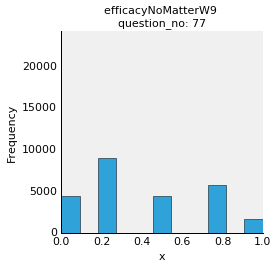
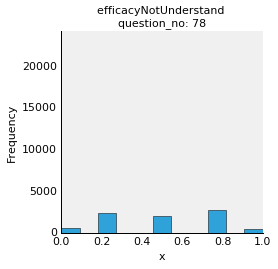
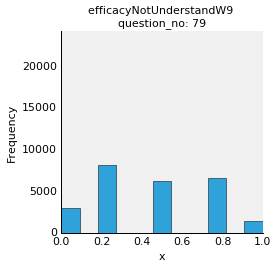
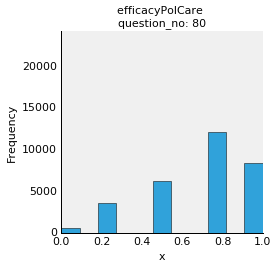
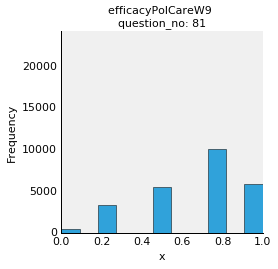
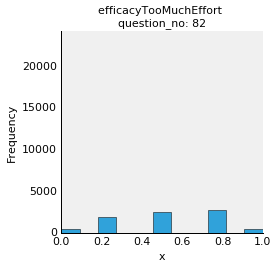
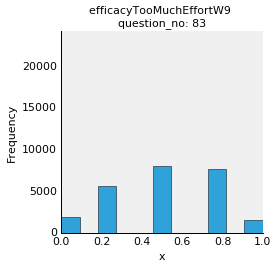
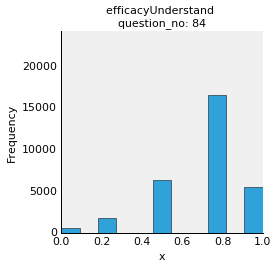
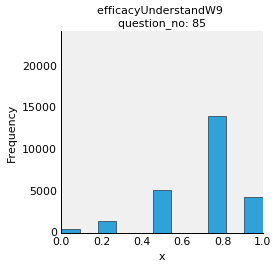
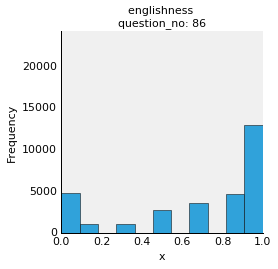
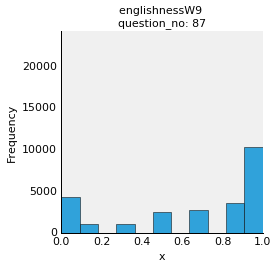
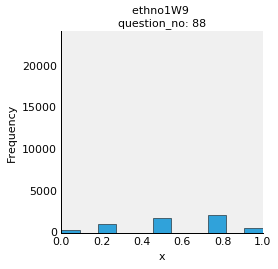
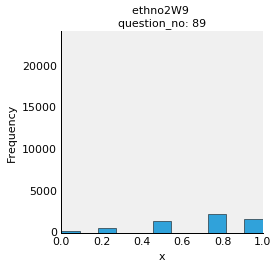
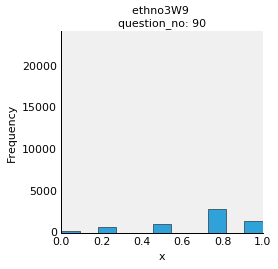
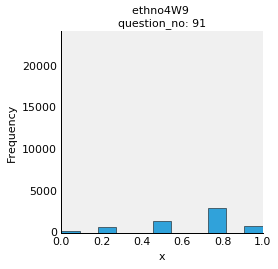
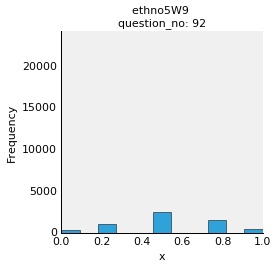
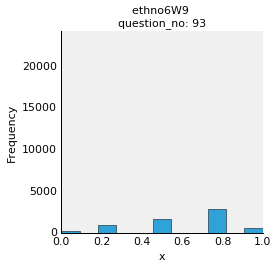
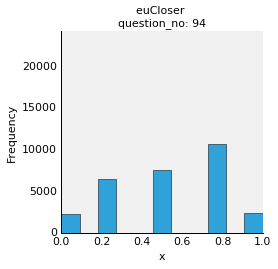
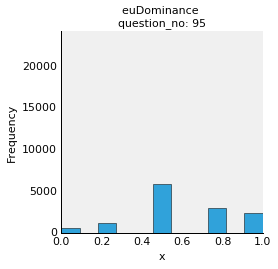
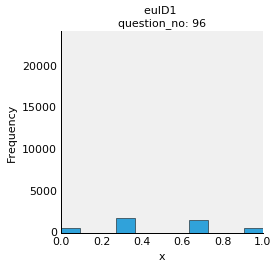
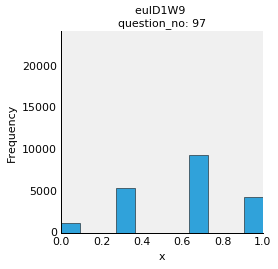
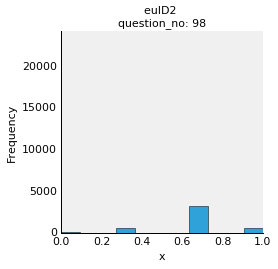
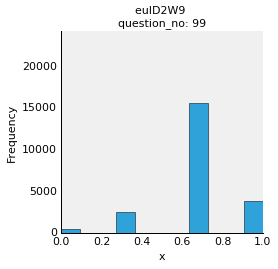
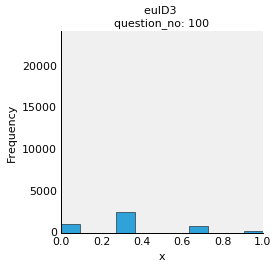
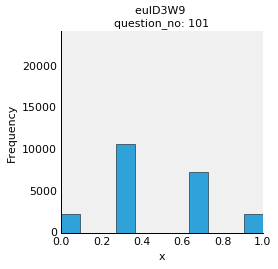
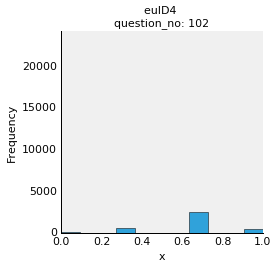
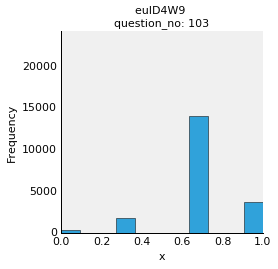
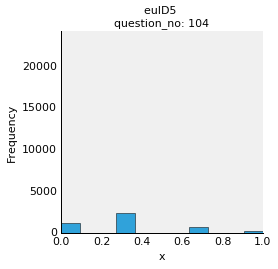
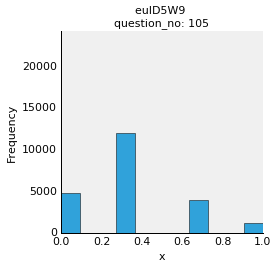
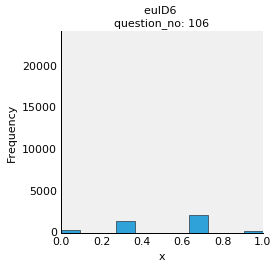
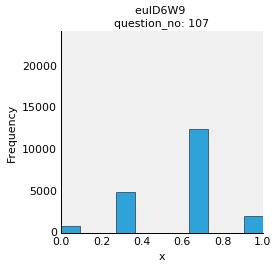
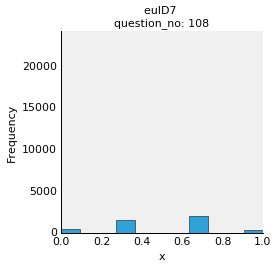
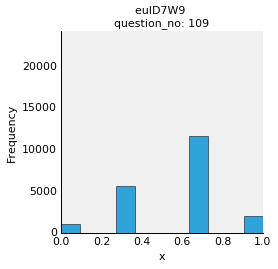
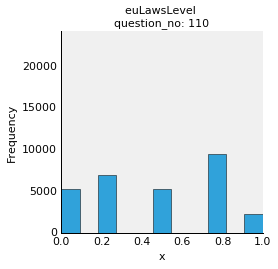
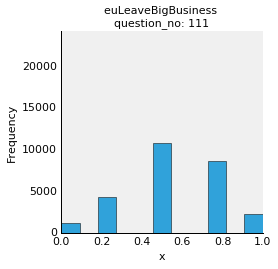
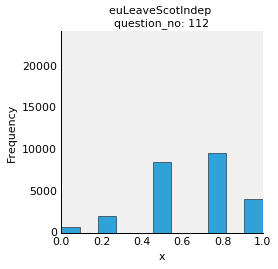
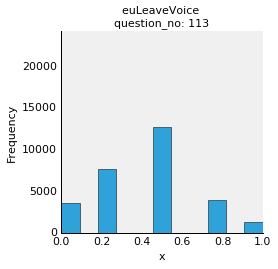
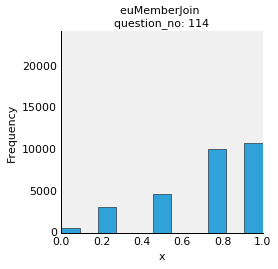
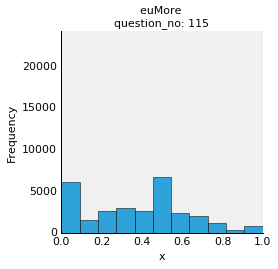
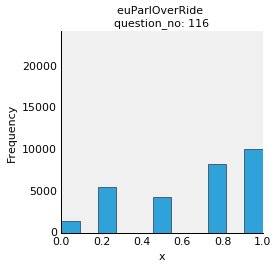
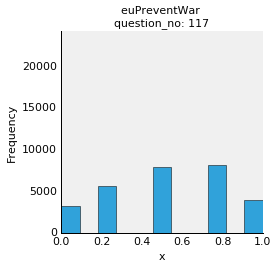
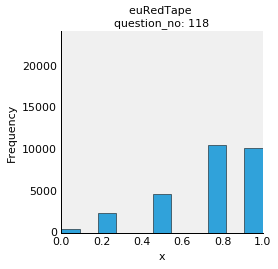
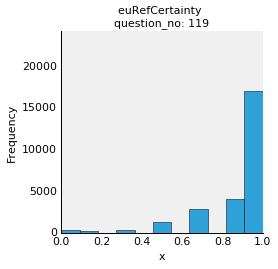
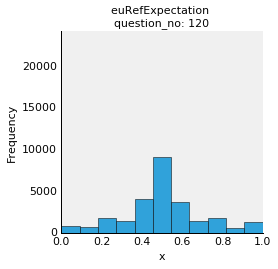
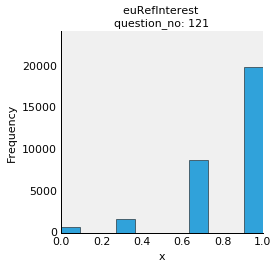
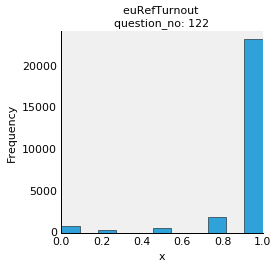
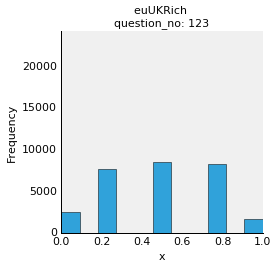
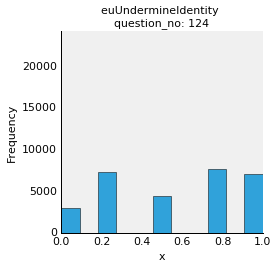
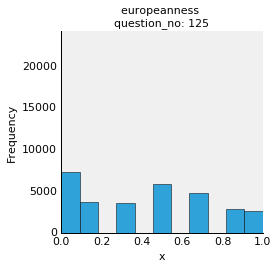
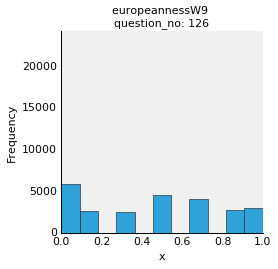
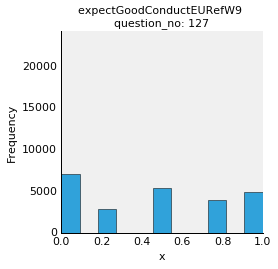
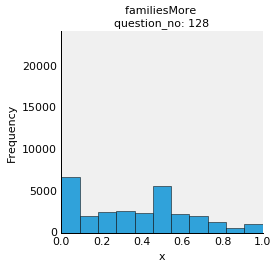
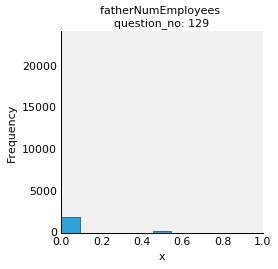
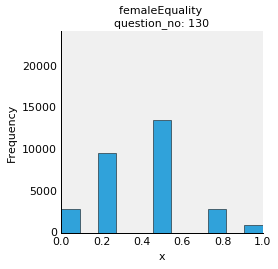
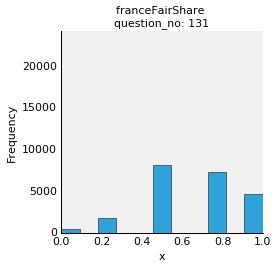
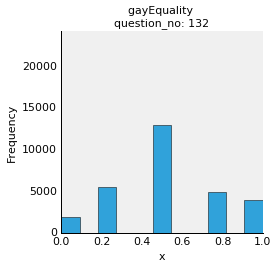
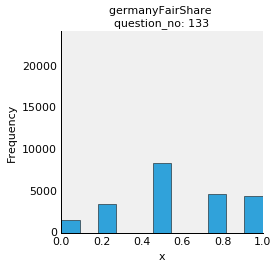
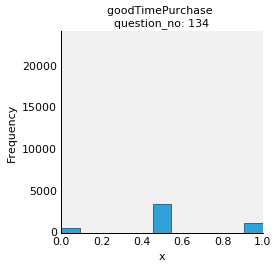
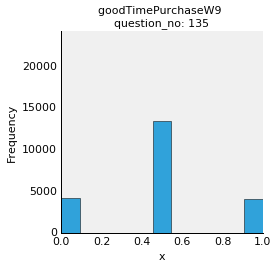
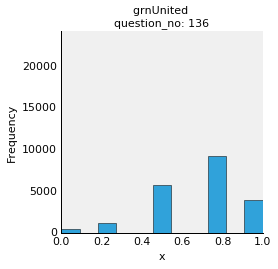
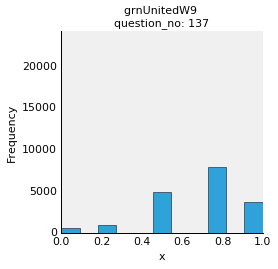
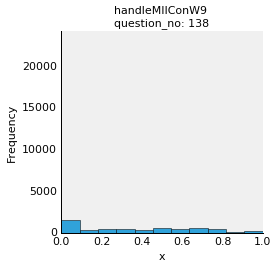
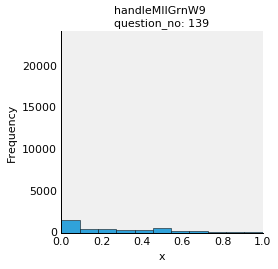
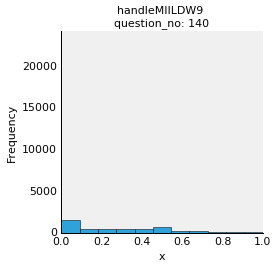
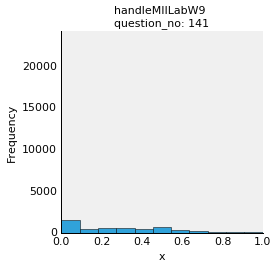
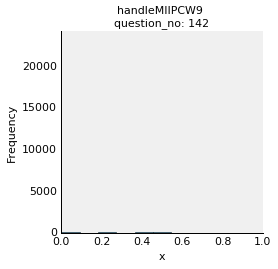
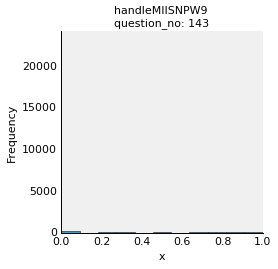
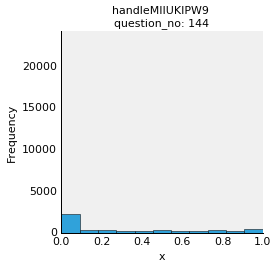
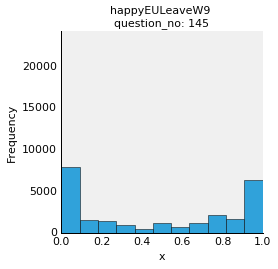
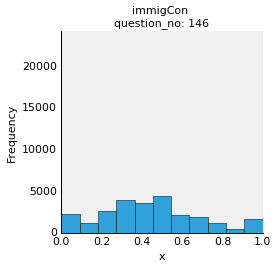
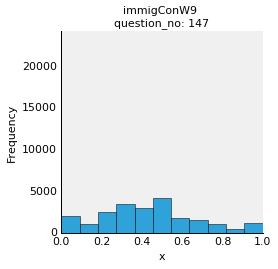
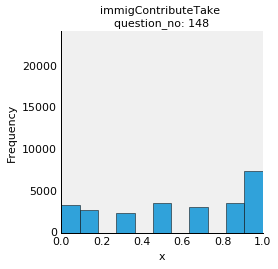
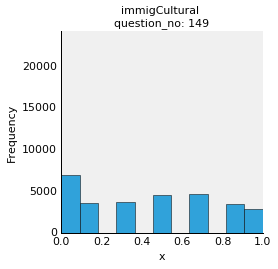
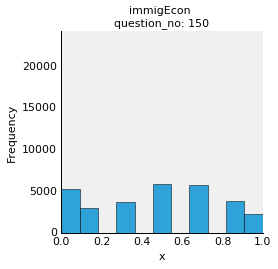
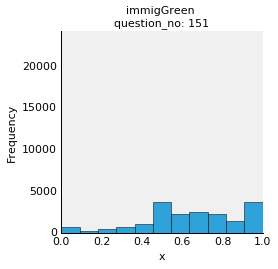
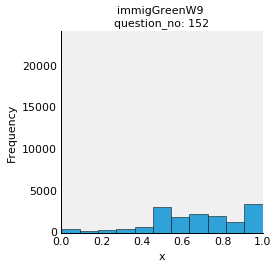
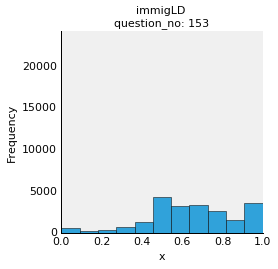
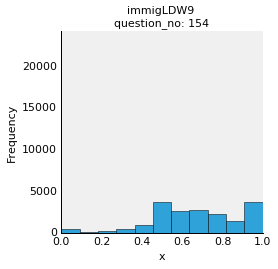
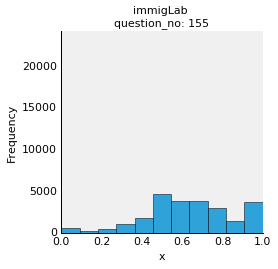
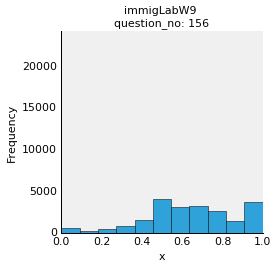
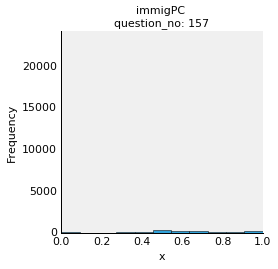
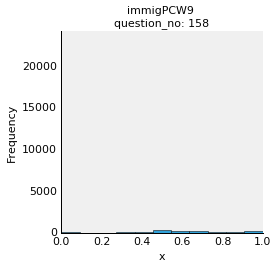
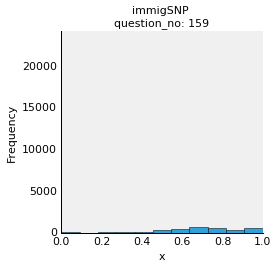
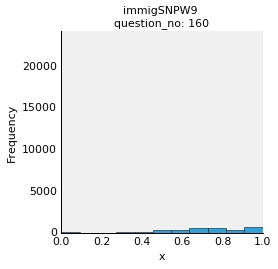
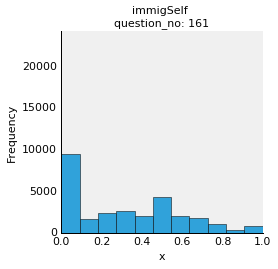
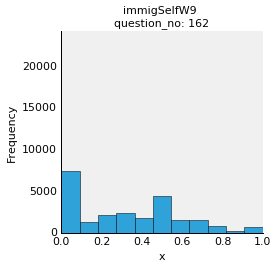
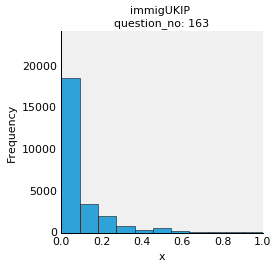
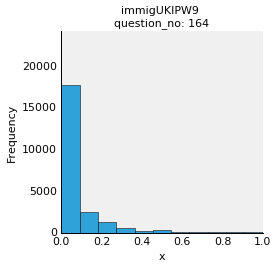
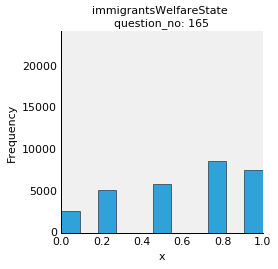
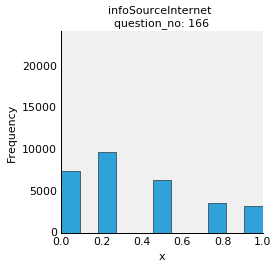
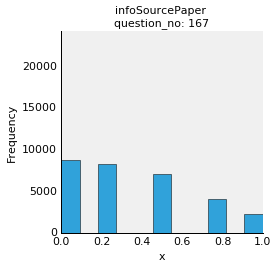
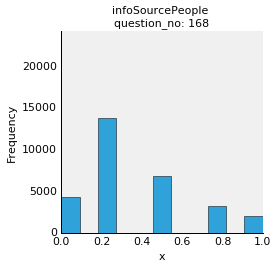
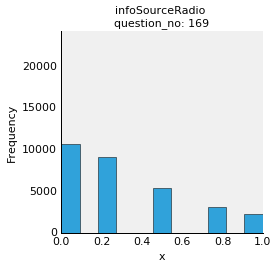
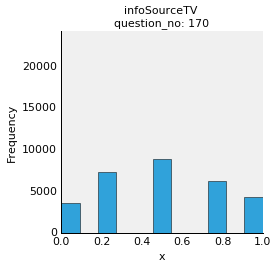
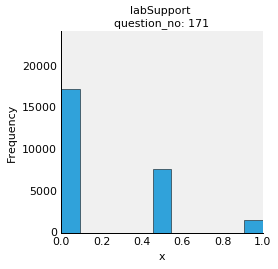
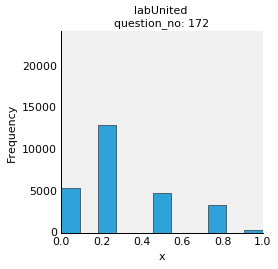
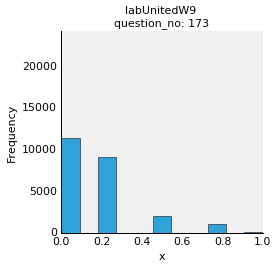
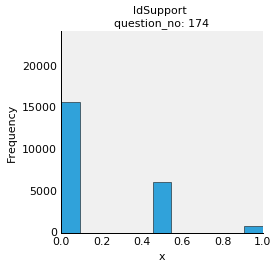
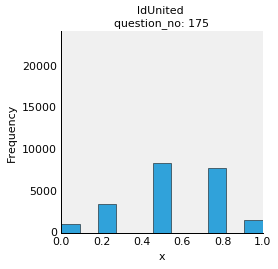
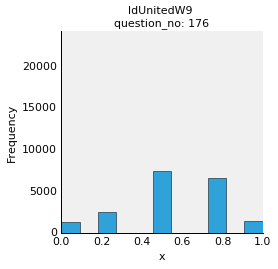
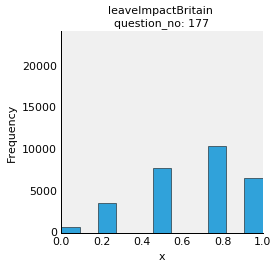
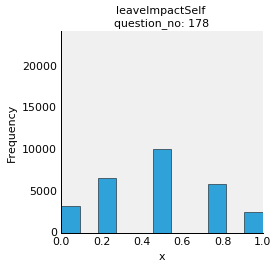
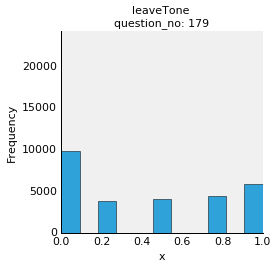
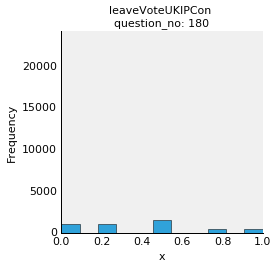
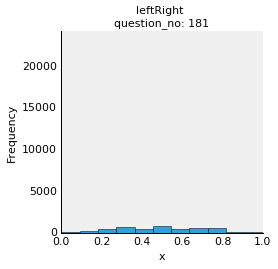
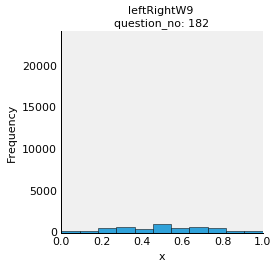
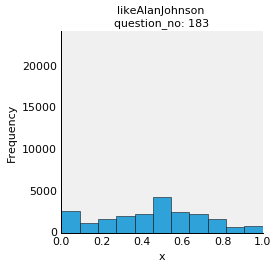
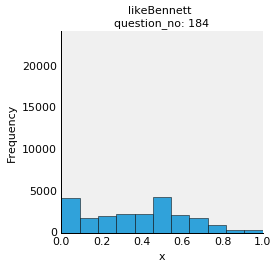
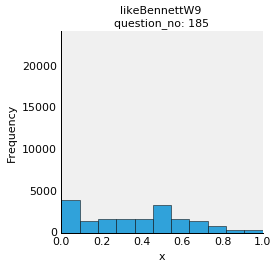
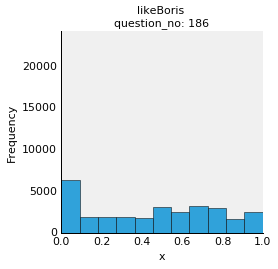
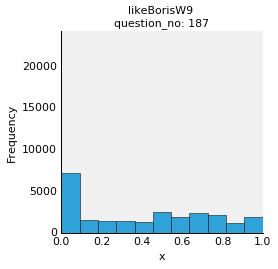
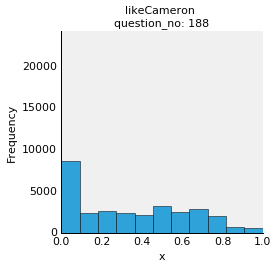
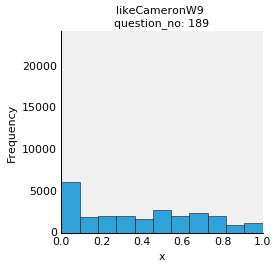
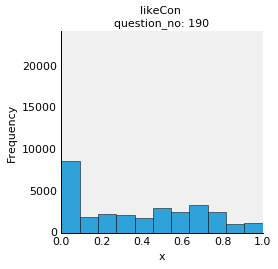
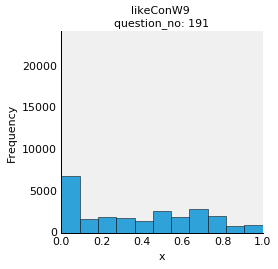
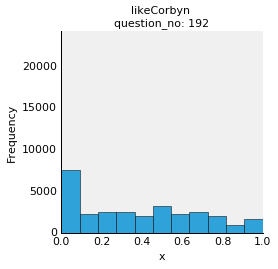
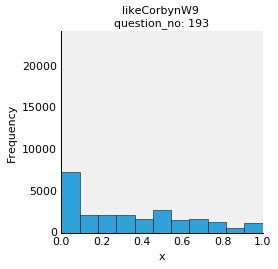
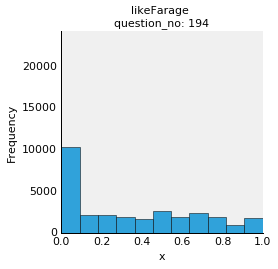
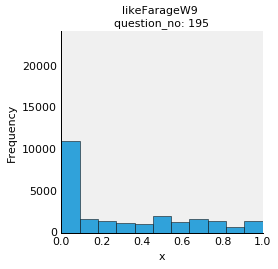
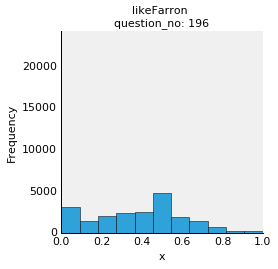
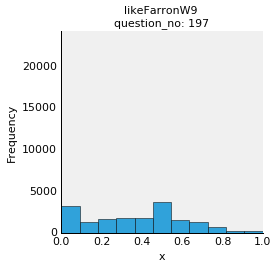
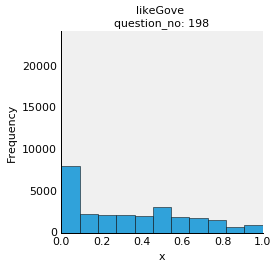
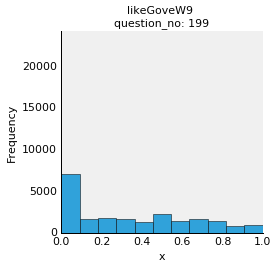
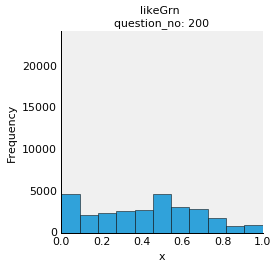
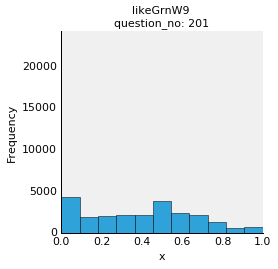
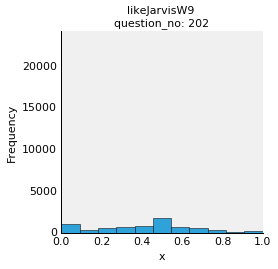
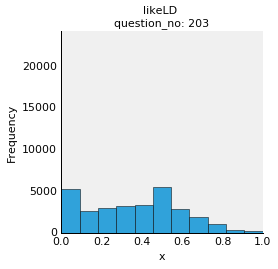
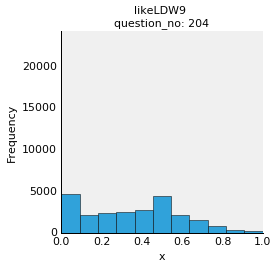
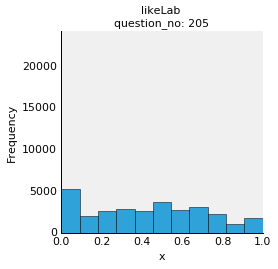
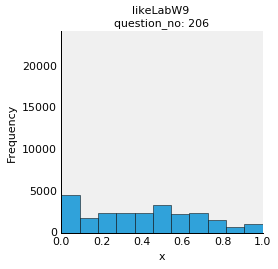
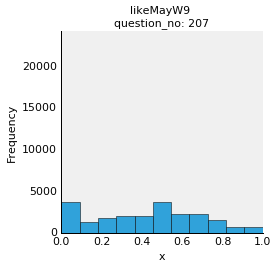
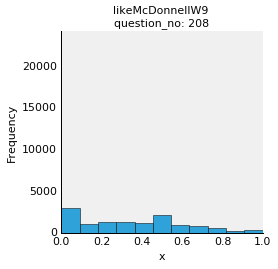
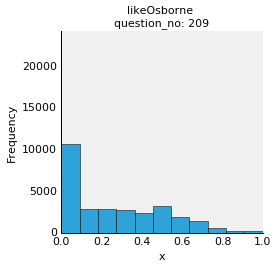
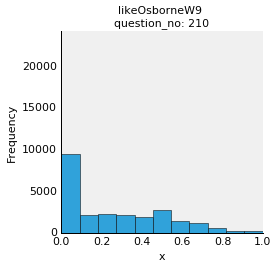
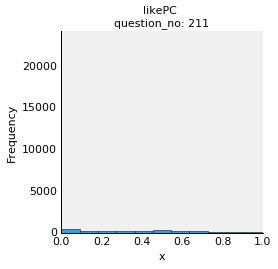
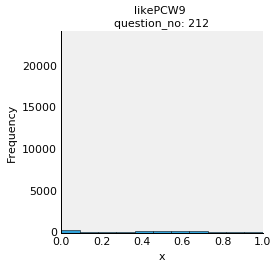
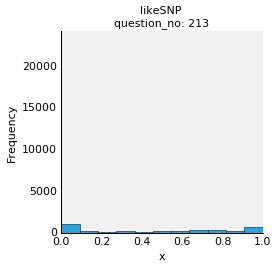
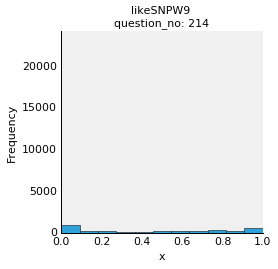
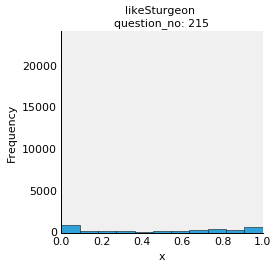
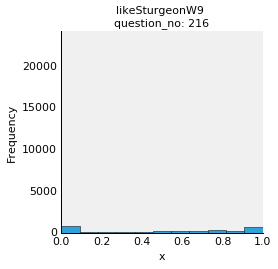
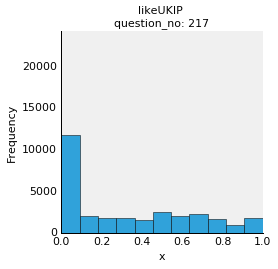
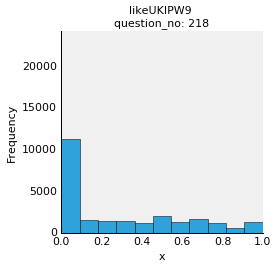
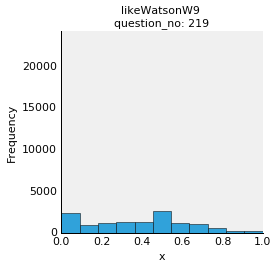
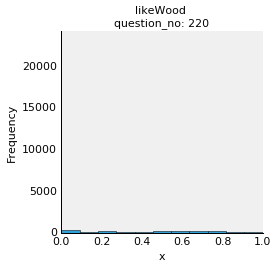
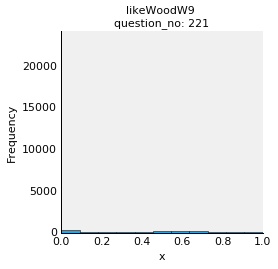
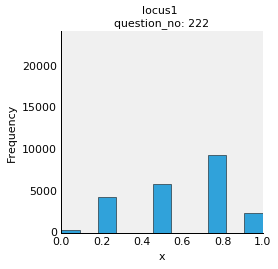
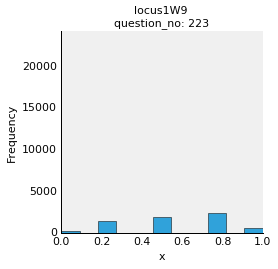
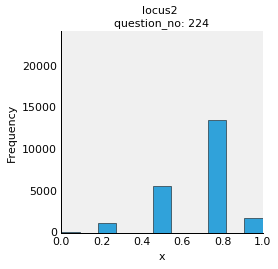
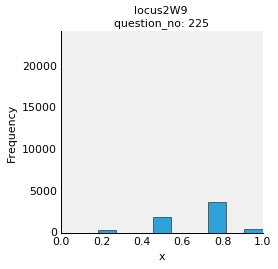
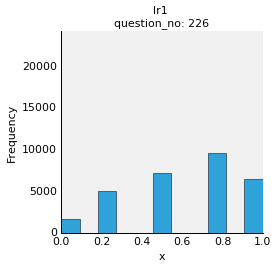
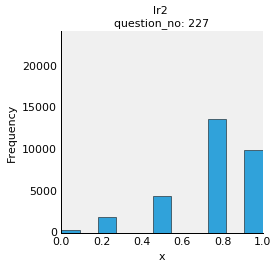
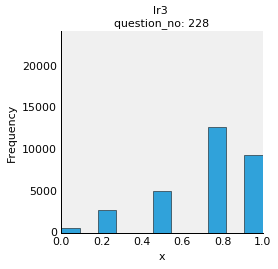
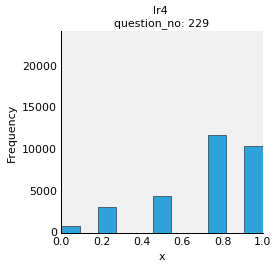
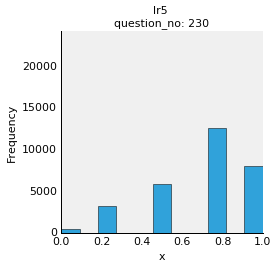
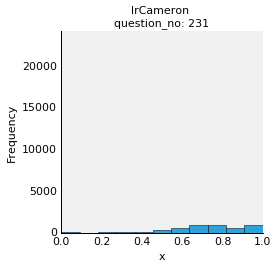
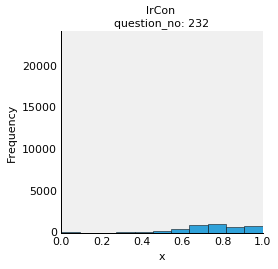
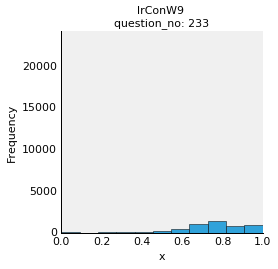
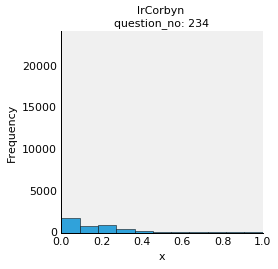
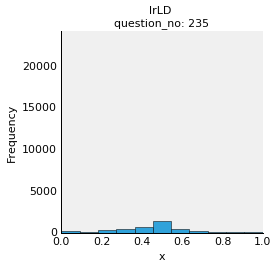
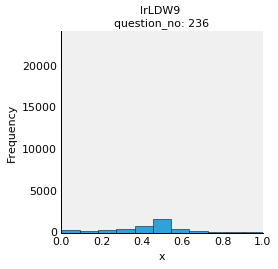
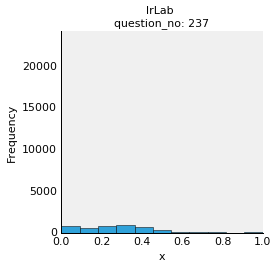
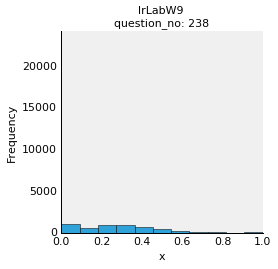
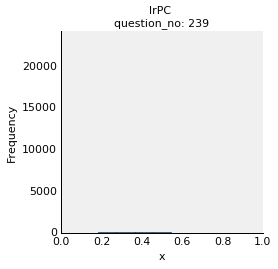
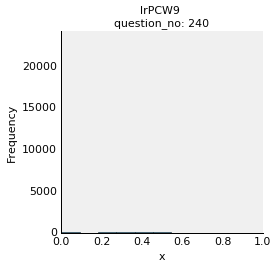
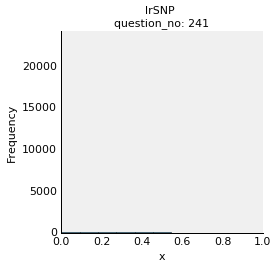
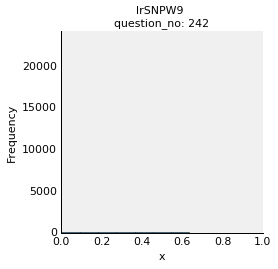
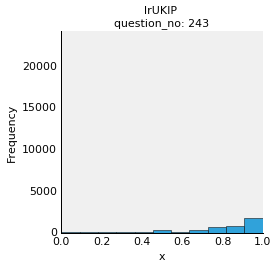
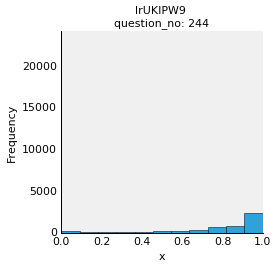
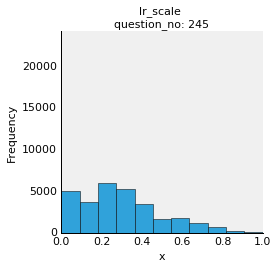
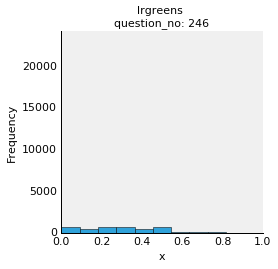
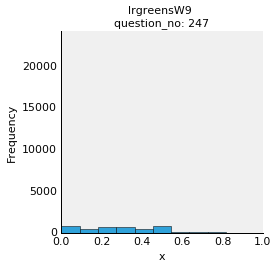
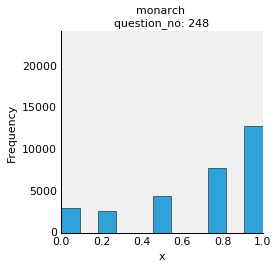
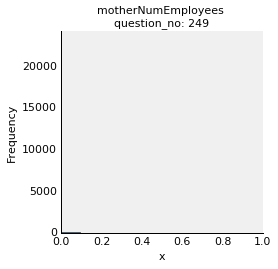
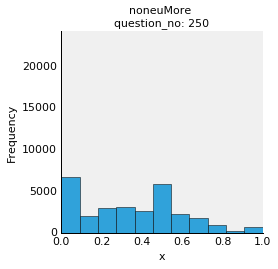
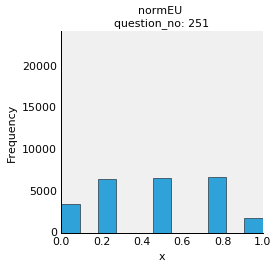
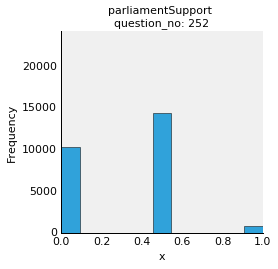
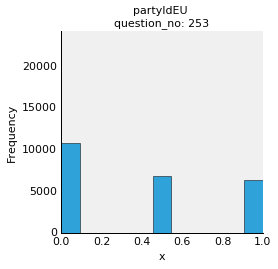
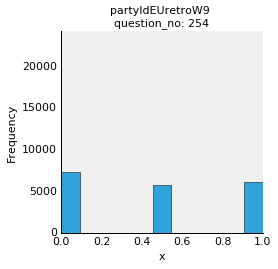
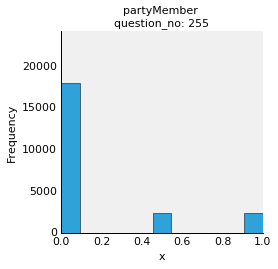
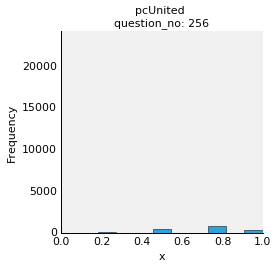
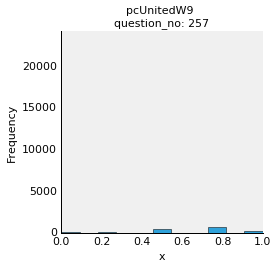
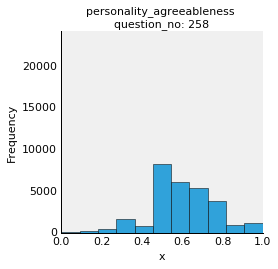
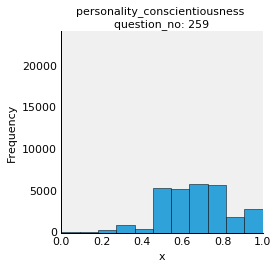
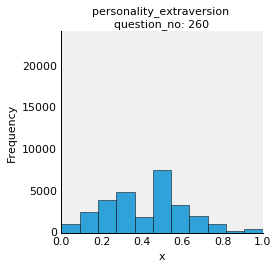
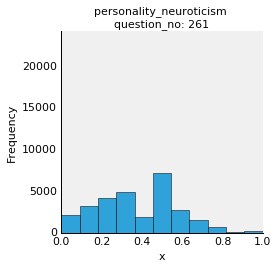
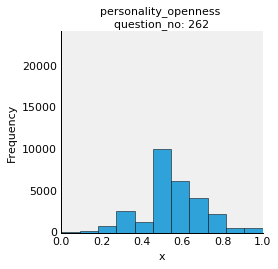
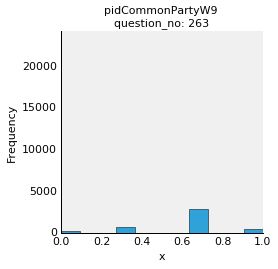
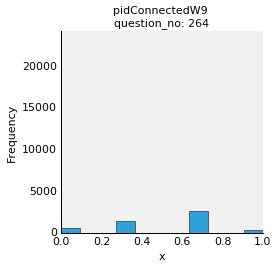
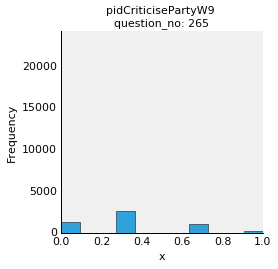
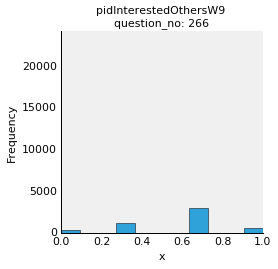
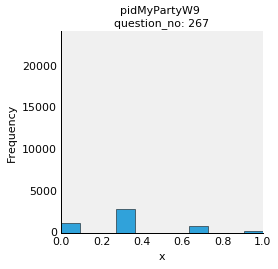
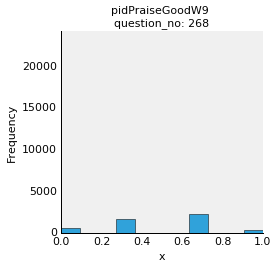
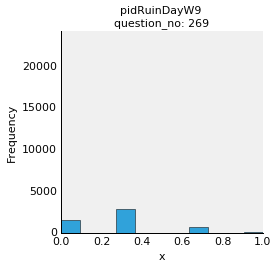
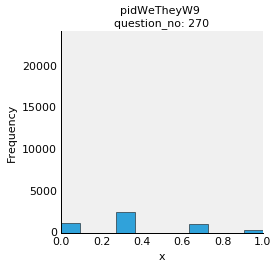
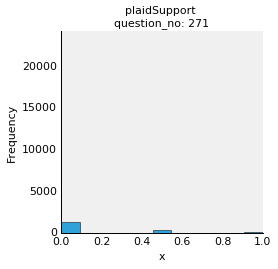
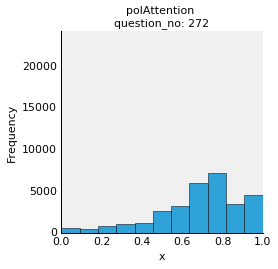
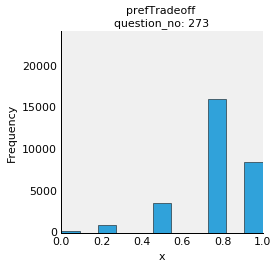
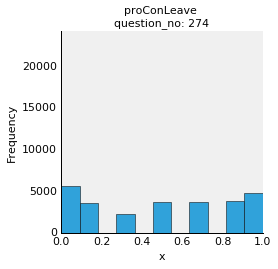
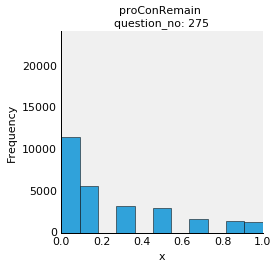
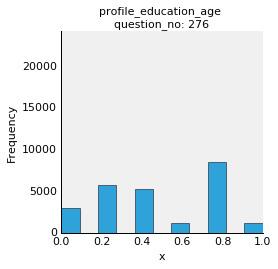
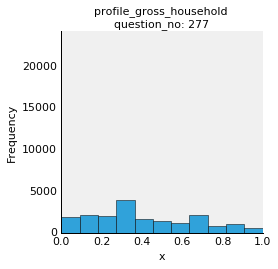
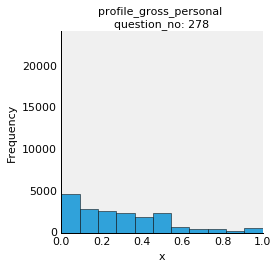
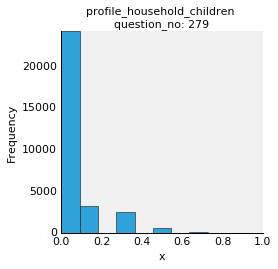
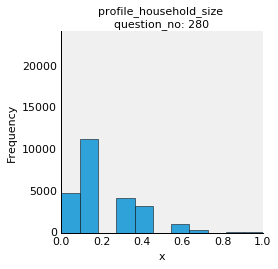
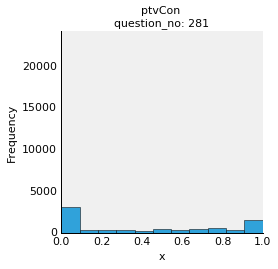
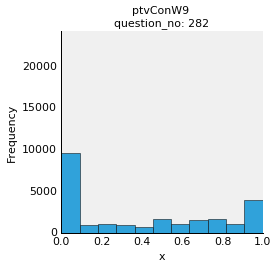
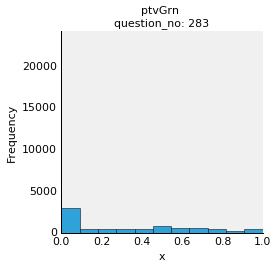
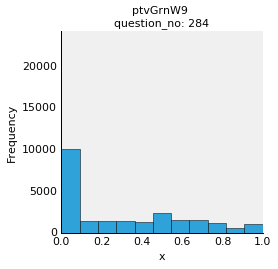
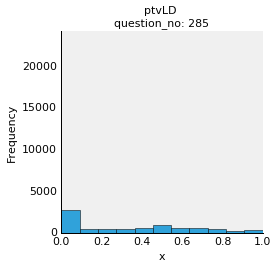
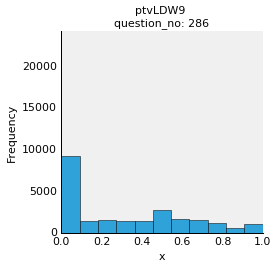
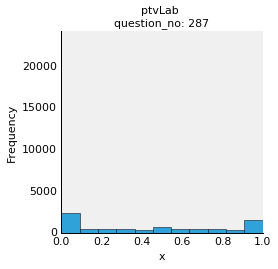
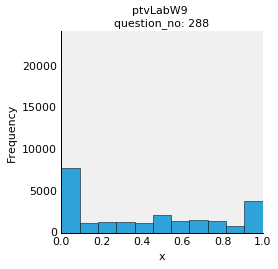
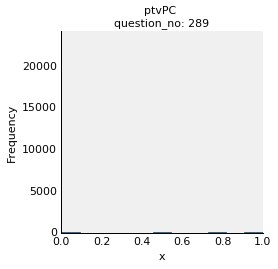
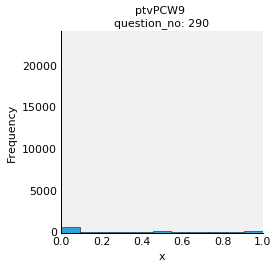
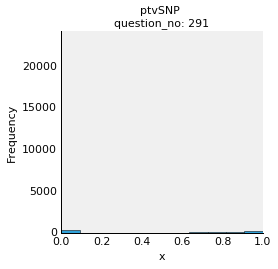
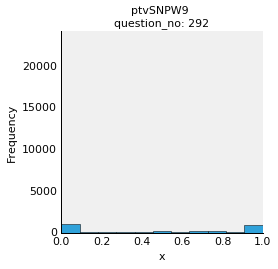
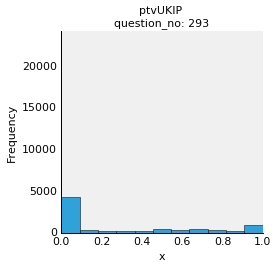
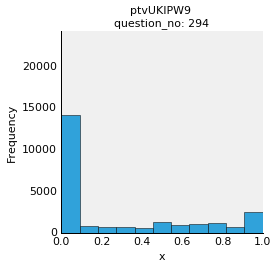
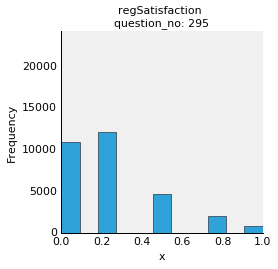
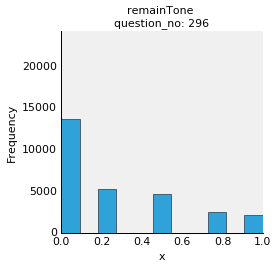
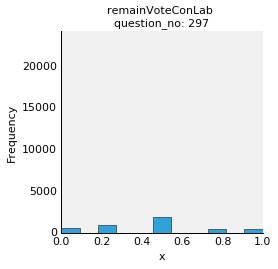
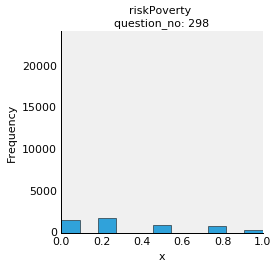
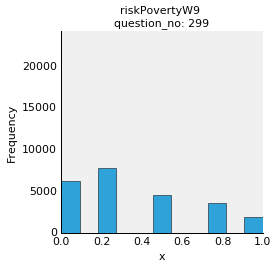
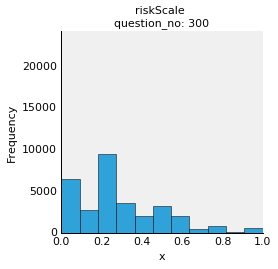
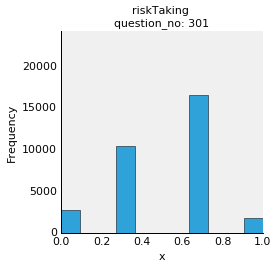
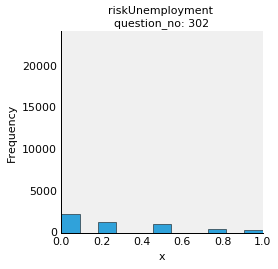
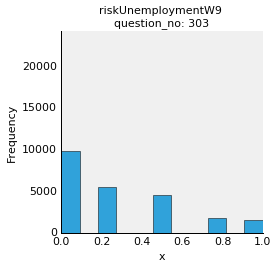
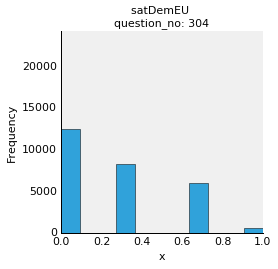
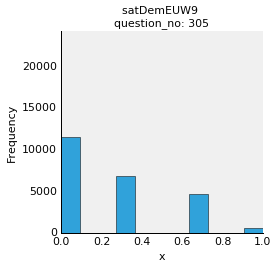
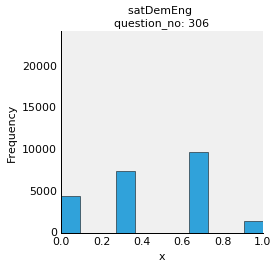
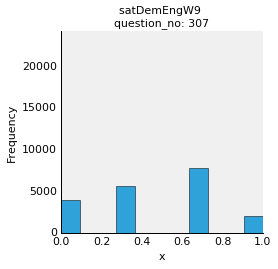
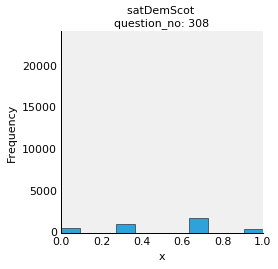
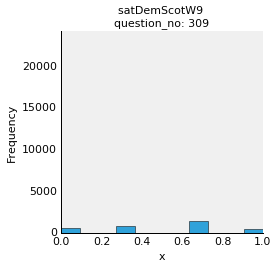
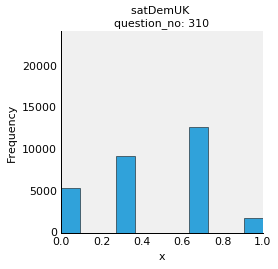
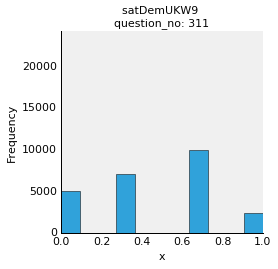
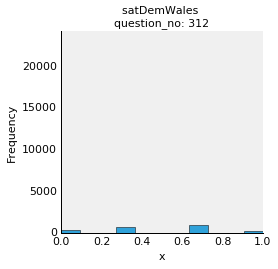
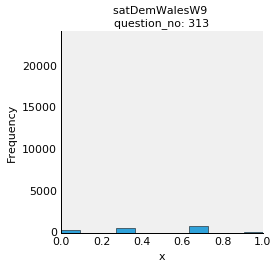
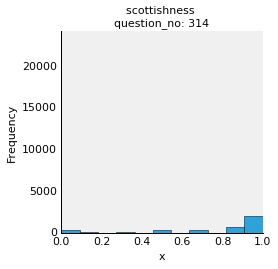
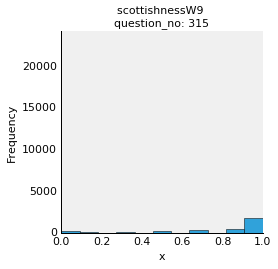
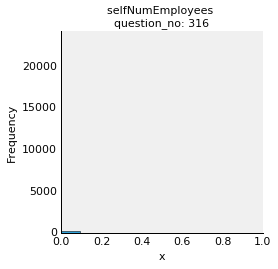
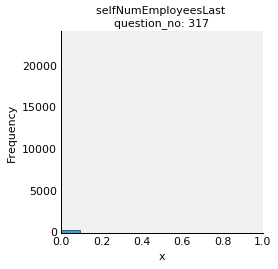
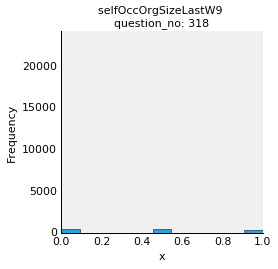
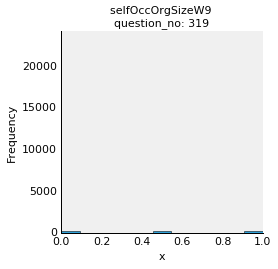
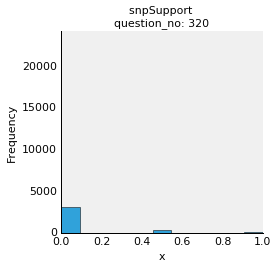
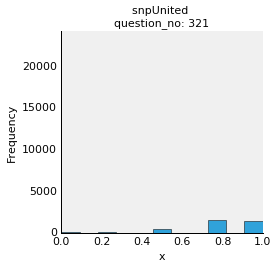
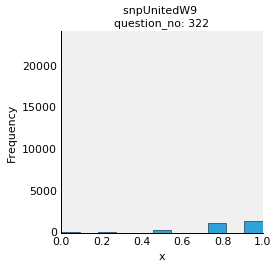
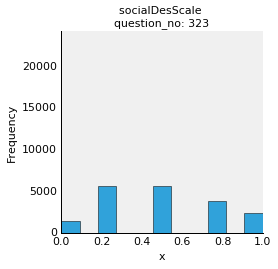
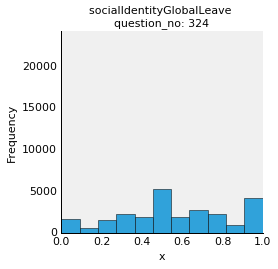
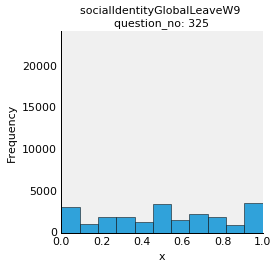
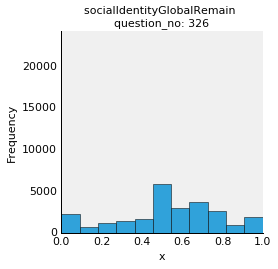
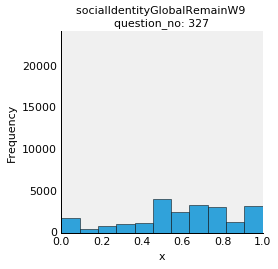
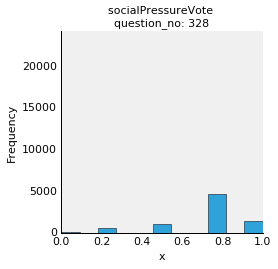
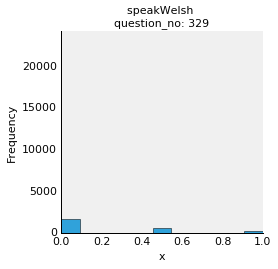
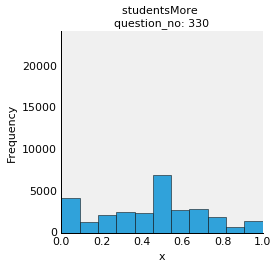
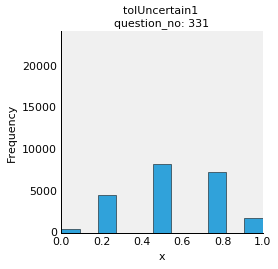
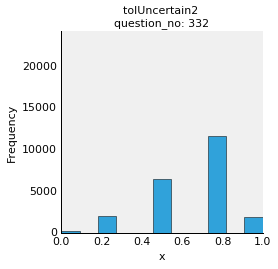
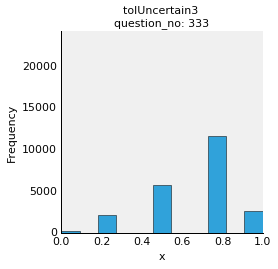
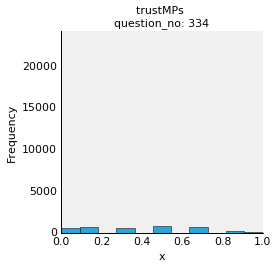
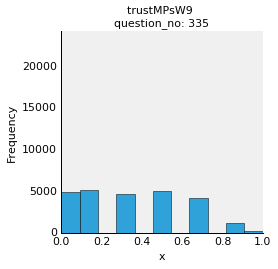
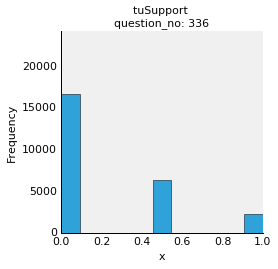
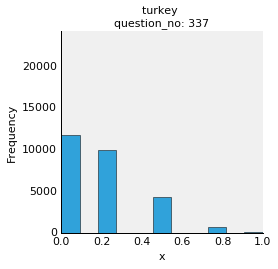
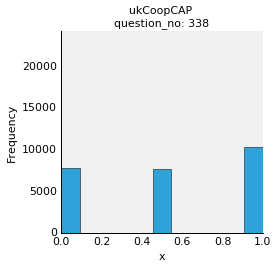
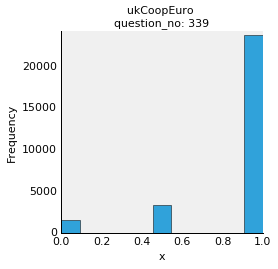
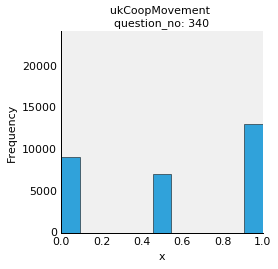
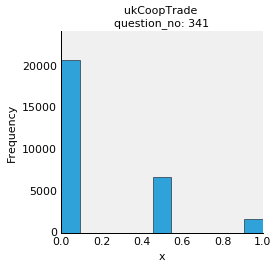
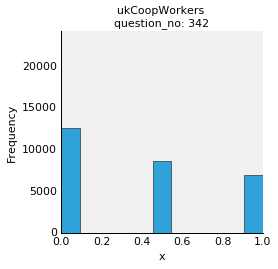
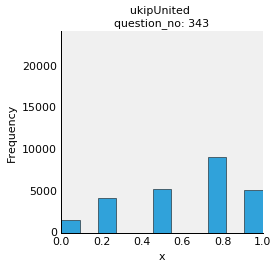
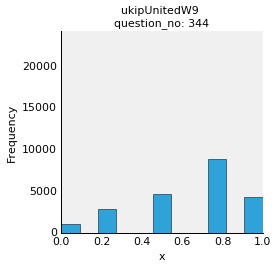
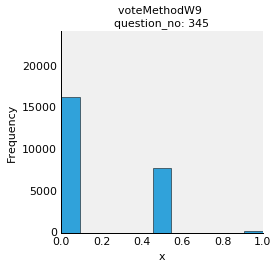
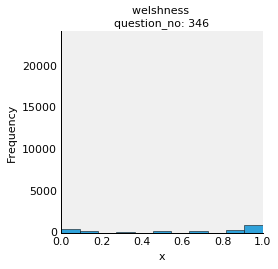
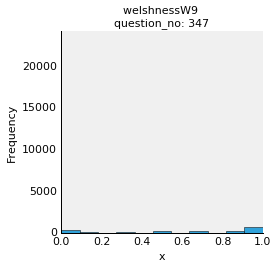

In [9]:
tables = hv.HoloMap(kdims=['question_no'])
bars   = hv.HoloMap(kdims=['question_no'])
hists  = hv.HoloMap(kdims=['question_no'])

x_dim = hv.Dimension("x",values = list( range(0,101) ))

for ques_no in range(0, len(ordinal_more_than_two_opts) ):

                     #len(ordinal_more_than_two_opts)):
    ques = ordinal_more_than_two_opts[ques_no]
#     print(ques)
    
    vcs = BES_numeric[ques].value_counts().sort_index()
    a = pd.DataFrame( [vcs.index, vcs.values] ).T
    a.columns = ["x","frequency"]
    
#     b = list(set( range(0,101) ).difference(  a.x  ))
#     c = pd.DataFrame([b,list(np.zeros(len(b)))]).T
#     c.columns = ["x","frequency"]
#     a = a.append(c)    
    
    
#     hv.Table( a ) + hv.Bars( a )

    tables[ques_no] = hv.Table( a )
    bars[ques_no]   = hv.Bars(  a )
    
    min_vals = np.min( BES_numeric[ques] )
    max_vals = np.max( BES_numeric[ques] )

    edges, data = np.histogram( (BES_numeric[ques].dropna() - min_vals)/(max_vals-min_vals), bins=11 )
    hists[ques_no] = hv.Histogram(edges, data, label=ques)    
    
    
#     tables[wave] = hv.Table( ct, kdims=[x_dim], vdims =[y_dim] )
#     bars[wave]   = hv.Bars(  ct, kdims=[x_dim], vdims =[y_dim] )     
    
    
# hv.Table( BES_numeric[ques].value_counts() )

# tables + bars
# %%opts size = 300
# bars[0:9]
# tables + hists
hists
# tables
#+ bars

In [35]:
# vcs = BES_numeric[ques].value_counts().sort_index()
# a = pd.DataFrame( [vcs.index, vcs.values] ).T
# a.columns = ["hhhhh","dfgdfgfd"]
# hv.Table( a ) + hv.Bars( a )
#list( range(0,101) )
# a.index.intersection( set( range(0,101) ) )

# a[ list(set( range(0,101) ).difference(  a.x  )) ] = 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000BD9CA90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000EE76A58>]], dtype=object)

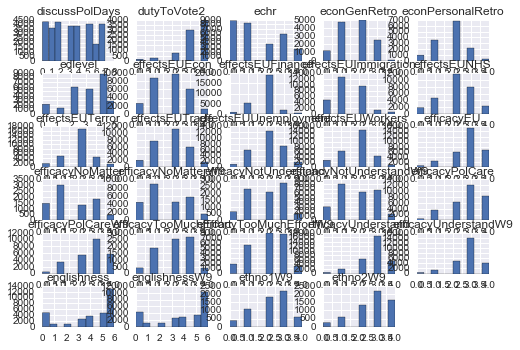

In [6]:
BES_numeric[ordinal_more_than_two_opts[61:90]].hist()

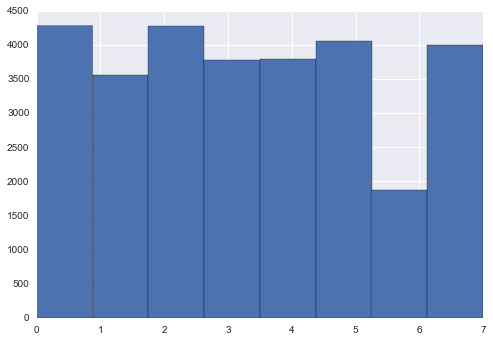

In [7]:
BES_numeric["discussPolDays"].hist(bins=8)

In [8]:
BES_numeric["discussPolDays"].value_counts().sort_index()

0.0    4283
1.0    3559
2.0    4273
3.0    3787
4.0    3801
5.0    4063
6.0    1877
7.0    3997
Name: discussPolDays, dtype: int64

In [75]:
import scipy
zscore_dict = dict()
pscore_dict = dict()

for col in BES_numeric[ordinal_more_than_two_opts].columns:
    (a,b) = scipy.stats.mstats.normaltest(BES_numeric[col].dropna())
    zscore_dict[col] = a
    pscore_dict[col] = b
zscore_series = pd.DataFrame.from_dict(zscore_dict,orient='index')[0]
pscore_series = pd.DataFrame.from_dict(pscore_dict,orient='index')[0]

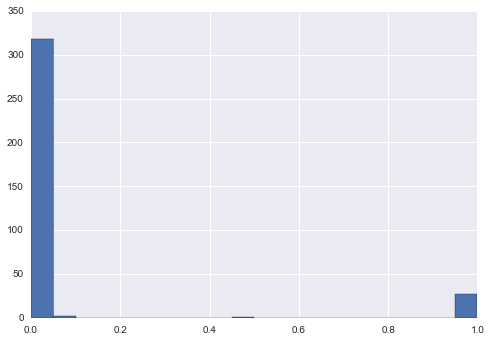

In [85]:
pscore_series.hist(bins=20)


In [86]:
pscore_series[pscore_series==1.0].index

Index(['expectGoodConductEURefW9', 'ukCoopWorkers', 'likeSNP',
       'selfOccOrgSizeW9', 'ptvSNPW9', 'al2', 'ptvLabW9', 'ptvPC', 'ukCoopCAP',
       'proConLeave', 'ukCoopMovement', 'likeSturgeon', 'ptvConW9',
       'likeBorisW9', 'leaveTone', 'happyEULeaveW9', 'ptvCon', 'partyIdEU',
       'likeSturgeonW9', 'selfOccOrgSizeLastW9', 'profile_education_age',
       'handleMIISNPW9', 'likeSNPW9', 'partyIdEUretroW9', 'ptvLab', 'anyUniW9',
       'ptvSNP'],
      dtype='object')

In [64]:
zscore_series[zscore_series>zscore_series.quantile(.9)].index

Index(['immigCultural', 'likeConW9', 'euUndermineIdentity', 'immigUKIP',
       'europeannessW9', 'immigUKIPW9', 'likeCorbyn', 'europeanness',
       'likeFarage', 'ukCoopEuro', 'certaintyEULD', 'euRefTurnout',
       'likeCameronW9', 'likeCon', 'EUIntegrationUKIP', 'immigContributeTake',
       'socialIdentityGlobalLeaveW9', 'echr', 'euLawsLevel', 'likeBoris',
       'discussPolDays', 'likeCameron', 'EUIntegrationSelfW9',
       'profile_household_children'],
      dtype='object')

In [65]:
zscore_series[zscore_series<zscore_series.quantile(.1)].index

Index(['lrSNPW9', 'euDominance', 'effectsEUWorkers', 'EUIntegrationPC',
       'personality_agreeableness', 'selfNumEmployees', 'immigPC',
       'econPersonalRetro', 'euID6', 'lrPC', 'effectsEUUnemployment', 'lrLDW9',
       'euLeaveVoice', 'pcUnited', 'euID7', 'lrgreensW9', 'satDemWalesW9',
       'lrgreens', 'handleMIIPCW9', 'motherNumEmployees', 'lrPCW9', 'lrSNP',
       'pcUnitedW9', 'ethno5W9', 'lrLD', 'approveWelshGovtW9', 'immigPCW9',
       'remainVoteConLab', 'goodTimePurchase'],
      dtype='object')

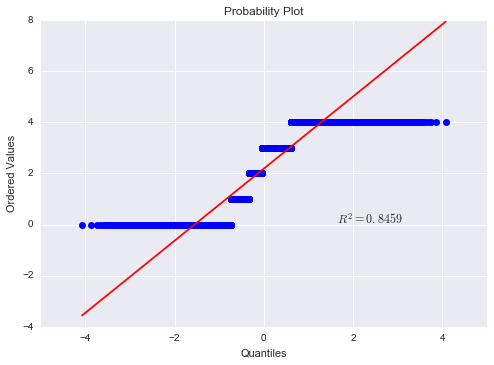

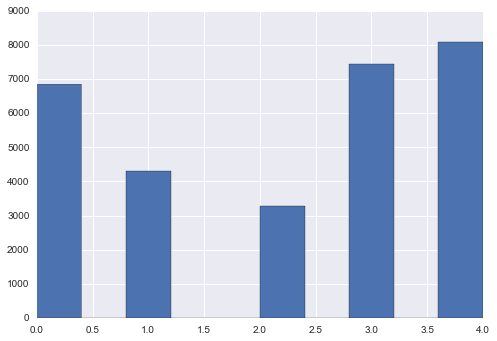

In [88]:
from scipy import stats
import matplotlib.pyplot as plt

col = 'al2'

fig = plt.figure()
res = stats.probplot(BES_numeric[col].dropna(), plot=plt)
plt.show()
BES_numeric[col].hist()

In [ ]:
# You need to standardise the data first!

# http://yeolab.github.io/flotilla/docs-stable/_modules/flotilla/compute/infotheory.html

def binify(df, bins):
    """Makes a histogram of each column the provided binsize

    Parameters
    ----------
    data : pandas.DataFrame
        A samples x features dataframe. Each feature (column) will be binned
        into the provided bins
    bins : iterable
        Bins you would like to use for this data. Must include the final bin
        value, e.g. (0, 0.5, 1) for the two bins (0, 0.5) and (0.5, 1).
        nbins = len(bins) - 1

    Returns
    -------
    binned : pandas.DataFrame
        An nbins x features DataFrame of each column binned across rows
    """
    if bins is None:
        raise ValueError('Must specify "bins"')
    binned = df.apply(lambda x: pd.Series(np.histogram(x, bins=bins)[0]))
    binned.index = bin_range_strings(bins)

    # Normalize so each column sums to 1
    binned = binned / binned.sum().astype(float)
    return binned


def entropy(binned, base=2):
    """Find the entropy of each column of a dataframe

    Parameters
    ----------
    binned : pandas.DataFrame
        A nbins x features DataFrame of probability distributions, where each
        column sums to 1
    base : numeric
        The log-base of the entropy. Default is 2, so the resulting entropy
        is in bits.

    Returns
    -------
    entropy : pandas.Seires
        Entropy values for each column of the dataframe.
    """
    return -((np.log(binned) / np.log(base)) * binned).sum(axis=0)